# Chain of Thought Reasoning Training

### Installation

In [ ]:
from google.colab import drive
from google.colab import userdata
from huggingface_hub import login
import os, wandb


drive.mount('/content/drive')

os.environ["HF_HOME"] = "/content/.cache/hf"
os.environ["TRANSFORMERS_CACHE"] = "/content/.cache/hf"
os.environ["WANDB_DIR"] = "/content/wandb"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

# Loging to Hugginigface
login(token=userdata.get('HUGGINGFACE_API'))

# Loging to W&B
wandb.login(key=userdata.get('WB_TOKEN'),relogin=True)

Mounted at /content/drive


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer tqdm
    !pip install --no-deps unsloth

### Load trained model from stage one

In [ ]:
from huggingface_hub import snapshot_download

repo_id = "parsa-mhmdi/RadLLamaThinking_Stage1_Final"
local_checkpoint_dir = "./parsa-mhmdi/RadLLamaThinking_Stage1_Final"  # Or any local path you prefer

# Download only the specific checkpoint subfolder
snapshot_download(
    repo_id=repo_id,
    local_dir=local_checkpoint_dir,
    repo_type="model"  # Default, but explicit for clarity
)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/638 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/420M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

In [ ]:
!rm -rf /content/parsa-mhmdi/RadLLamaThinking_Stage1_Final/adapter_config.json

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

local_checkpoint_dir = "./parsa-mhmdi/RadLLamaThinking_Stage1_Final"  # Or any local path you prefer

model, tokenizer = FastVisionModel.from_pretrained(
    local_checkpoint_dir,
    max_seq_length=2048,
    load_in_4bit=True, # Specify load_in_4bit here if you want to load the PEFT model in 4bit
    use_gradient_checkpointing="unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.5: Fast Mllama patching. Transformers: 4.56.1.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = False, # False if not finetuning MLP layers

    r = 8,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0.2,
    bias = "none",
    random_state = 3407,
    use_rslora   = True,                       # rank‑stabilised LoRA
    target_modules       = ["q_proj", "k_proj", "v_proj", "o_proj"],
    layers_to_transform  = "top-12",        # or "top-8" etc.
    loftq_config = None,
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.2.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `model.base_model.model.model.vision_model.transformer` require gradients


## Load Data

In [ ]:
# --- Install Hugging Face Hub ---
!pip -q install -U "huggingface_hub[hf_transfer]"

# --- Imports ---
import os
from huggingface_hub import snapshot_download, login
from google.colab import userdata

# --- Load HF token from Colab secrets ---
HF_TOKEN = userdata.get("HF_TOKEN")
login(token=HF_TOKEN)

# --- Enable faster transfers ---
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

# --- Download dataset locally ---
local_dir = "/content/CoT-Reasoning-CXR"
dataset_repo = "parsa-mhmdi/CoT-Reasoning-CXR"

download_dir = snapshot_download(
    repo_id=dataset_repo,
    repo_type="dataset",
    local_dir=local_dir,
    token=HF_TOKEN,
)

print("✅ Dataset downloaded to:", download_dir)

# --- Unzip if .zip file exists inside repo ---
import zipfile

for fname in os.listdir(local_dir):
    if fname.endswith(".zip"):
        zip_path = os.path.join(local_dir, fname)
        extract_dir = os.path.join(local_dir, "unzipped")
        os.makedirs(extract_dir, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(extract_dir)
        print(f"✅ Unzipped {fname} to {extract_dir}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.6/562.6 kB 13.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.9.6 requires msgspec, which is not installed.
unsloth-zoo 2025.9.6 requires tyro, which is not installed.
unsloth 2025.9.5 requires tyro, which is not installed.
unsloth-zoo 2025.9.6 requires datasets<4.0.0,>=3.4.1, but you have datasets 4.0.0 which is incompatible.
unsloth 2025.9.5 requires datasets<4.0.0,>=3.4.1, but you have datasets 4.0.0 which is incompatible.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

Merged_CXR.zip:   0%|          | 0.00/7.81M [00:00<?, ?B/s]

✅ Dataset downloaded to: /content/CoT-Reasoning-CXR
✅ Unzipped Merged_CXR.zip to /content/CoT-Reasoning-CXR/unzipped


In [ ]:
# --- Dataloader for Merged (eager preload, not lazy) ---
import os, random
from PIL import Image
from torch.utils.data import Dataset

INSTRUCTION = (
    "Act as a board-certified radiologist specialized in adult chest radiography.\n"
    "Base every statement only on the provided image(s). If information is missing, say so.\n"
    "Use RSNA/ACR-style reporting sections and concise clinical language. Prioritize the IMPRESSION as a short, actionable summary.\n"
    "Use standardized terms (RadLex/CheXpert lexicon) and always include location, laterality, extent, and acuity.\n"
    "Handle uncertainty explicitly and never invent comparisons.\n"
    "Comment on study quality/limitations and devices/lines/tubes.\n"
    "Use EXACTLY these headers in order: Technique, View, Findings, Impression.\n"
)

class CXRReportDataset(Dataset):
    """
    Eagerly loads all (image, report) pairs into memory for fast training.
    Expected files per sample: image.(jpg|jpeg|png) + report.txt
    """
    def __init__(self, root_dir, instruction, preload=True, accepted_exts=(".jpg", ".jpeg", ".png")):
        self.items = []
        self.instruction = instruction
        dirs = [d for d in os.listdir(root_dir) if d.isdigit()]
        dirs = sorted(dirs, key=lambda x: int(x))
        for d in dirs:
            dpath = os.path.join(root_dir, d)
            if not os.path.isdir(dpath):
                continue
            # image: prefer `image.jpg`, else any accepted extension
            img_path = None
            preferred = os.path.join(dpath, "image.jpg")
            if os.path.exists(preferred):
                img_path = preferred
            else:
                for f in os.listdir(dpath):
                    low = f.lower()
                    if low.startswith("image.") and low.endswith(accepted_exts):
                        img_path = os.path.join(dpath, f)
                        break
                if img_path is None:
                    # fallback: first accepted extension
                    for f in os.listdir(dpath):
                        if f.lower().endswith(accepted_exts):
                            img_path = os.path.join(dpath, f)
                            break

            rpt_path = os.path.join(dpath, "report.txt")
            if img_path is None or not os.path.exists(rpt_path):
                continue

            with open(rpt_path, "r", encoding="utf-8", errors="ignore") as fh:
                report_text = fh.read().strip()

            if preload:
                # preload PIL image into RAM
                img = Image.open(img_path).convert("RGB")
            else:
                img = img_path  # will be opened in __getitem__

            self.items.append({
                "image": img,
                "report": report_text,
            })

        if len(self.items) == 0:
            raise RuntimeError(f"No valid samples found in {root_dir}")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        rec = self.items[idx]
        img = rec["image"]
        # If we stored a path (preload=False), open on access
        if isinstance(img, str):
            img = Image.open(img).convert("RGB")
        # Unsloth vision chat format (1 image + instruction -> report)
        messages = [
            {"role":"user","content":[{"type":"image"}, {"type":"text","text": self.instruction}]},
            {"role":"assistant","content":[{"type":"text","text": rec["report"]}]},
        ]
        return {
            "messages": messages,
            "images": [img],   # list of PIL images; one per sample
        }

# --- Build dataset + deterministic 80/10/10 split ---
merged_root = "/content/CoT-Reasoning-CXR/unzipped/content/Annotated_CXR_Reports/Annotated_CXR_Reports/Merged"
full_ds = CXRReportDataset(merged_root, INSTRUCTION, preload=True)

rand = random.Random(3407)  # deterministic
indices = list(range(len(full_ds)))
rand.shuffle(indices)

n = len(indices)
n_train = int(0.9 * n)
n_val   = int(0.1 * n)
train_idx = indices[:n_train]
# val_idx   = indices[n_train:n_train+n_val]
val_idx   = indices[n_train:]
# test_idx  = indices[n_train+n_val:]

class IndexDataset(Dataset):
    def __init__(self, base, indices):
        self.base = base
        self.indices = indices
    def __len__(self): return len(self.indices)
    def __getitem__(self, i): return self.base[self.indices[i]]

train_ds = IndexDataset(full_ds, train_idx)
val_ds   = IndexDataset(full_ds, val_idx)
# test_ds  = IndexDataset(full_ds, test_idx)

print(f"Samples: total={len(full_ds)} | train={len(train_ds)} val={len(val_ds)}")


Samples: total=300 | train=270 val=30


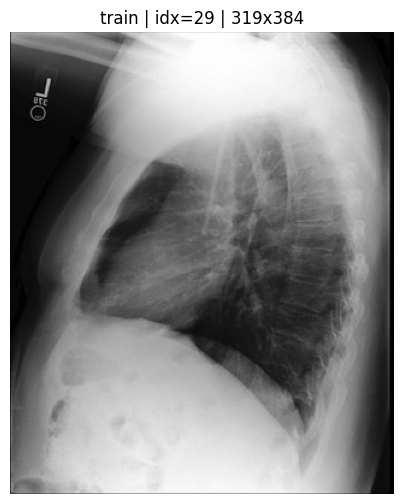

REPORT:
--------------------------------------------------------------------------------
<\<REASONING\_10\_STEPS>>

1. Single lateral chest radiograph; PA view referenced not shown; inspiration adequate; minimal motion; diagnostic quality.
2. Right central venous catheter mentioned—catheter position not confirmed on lateral image.
3. Cardiomediastinal silhouette normal; no cardiomegaly evident.
4. Trachea and main bronchi patent; no endobronchial occlusion.
5. Lungs clear without focal airspace consolidation or nodules.
6. Posterior costophrenic sulci sharp; no pleural effusion detected.
7. No pneumothorax; no visible pleural line.
8. Pulmonary vasculature not congested; no interstitial edema.
9. Thoracic spine shows mild degenerative changes; no acute osseous abnormality.
10. Synthesis: Normal lateral chest with clear lungs, intact pleura, and normal heart; central venous catheter status not confirmed; no pneumonia visualized.
    <\<END\_REASONS>>

<\<REPORT\_VERBATIM>>
FINAL REPORT


In [ ]:
# Visualize a random (image, report) pair from a chosen split
import random, textwrap
import matplotlib.pyplot as plt

# Pick which split to sample from: "train", "val", or "test"
SPLIT = "train"   # change to "val" or "test" if you like

ds_map = {"train": train_ds, "val": val_ds}
assert SPLIT in ds_map, f"Unknown split {SPLIT}"
ds = ds_map[SPLIT]

# Sample a random index
idx = random.randrange(len(ds))
sample = ds[idx]

# Our dataset returns Unsloth vision chat format + PIL image
img = sample["images"][0]  # PIL.Image
report = sample["messages"][1]["content"][0]["text"].strip()

# Show image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
try:
    w, h = img.size
    plt.title(f"{SPLIT} | idx={idx} | {w}x{h}")
except:
    plt.title(f"{SPLIT} | idx={idx}")
plt.show()

# Print report (truncate if very long)
MAX_CHARS = 2000
print("=" * 80)
print("REPORT:")
print("-" * 80)
print(report if len(report) <= MAX_CHARS else (report[:MAX_CHARS] + "…"))
print("=" * 80)
print(f"Total chars: {len(report)}")


## Train

In [ ]:
from transformers import EarlyStoppingCallback
from trl import SFTTrainer, SFTConfig
from unsloth import FastVisionModel, is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator

resume_training = False

FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=None,                 # we'll log eval_loss only here (your custom metrics callback can stay)
    args=SFTConfig(
        # ========= Evaluation =================
        eval_strategy="steps",      # <— key
        eval_steps=10,                   # <— key
        prediction_loss_only=True,        # only compute/return eval_loss

        # ========= Prevent overfitting =========
        # load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,

        # ========= Usual training setup =========
        num_train_epochs=10,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,

        warmup_ratio=0.03,
        learning_rate=1e-4,
        lr_scheduler_type="cosine",
        weight_decay=0.01,
        max_grad_norm=1.0,

        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),

        optim="adamw_torch_fused",
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant": False},

        # =============== Loggining =======================================
        logging_strategy="steps",
        logging_steps=1,

        # =============== Data Loader =====================================
        dataloader_num_workers=16,
        dataloader_prefetch_factor=2,
        dataloader_pin_memory=True,
        ignore_data_skip = True,

        # =============== Vision Fintuning ================================
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,

        # =============== Saving ==========================================
        save_strategy="steps",
        save_steps=10,                   # save at same cadence as eval
        save_total_limit=3,
        save_safetensors=True,  # Save checkpoints as safetensors

        # ================ Push to hub ===============================
        push_to_hub=True,
        hub_model_id="parsa-mhmdi/RadLLamaThinking_Stage2_Training2",
        hub_private_repo=False,
        hub_strategy="all_checkpoints",

        seed=3407,
        output_dir="/content/outputs",
        report_to="wandb",
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5,  # stop if no eval_loss improvement in 5 evals
                                     early_stopping_threshold=0.0)]
)


In [ ]:
trainer_stats = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'bos_token_id': 128000}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 270 | Num Epochs = 10 | Total steps = 170
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 11,796,480 of 10,682,017,315 (0.11% trained)


Step,Training Loss,Validation Loss
10,1.479200,1.415387
20,1.211000,1.171888
30,1.077800,1.011251
40,0.966900,0.924713
50,0.911700,0.871984
60,0.928800,0.838514
70,0.824500,0.814115
80,0.827800,0.794493
90,0.797900,0.781077
100,0.778500,0.769925


Unsloth: Not an error, but MllamaForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


## Merge weights and push to huggingface

### Downlod Trained Model

In [ ]:
from huggingface_hub import snapshot_download

repo_id = "parsa-mhmdi/RadLLamaThinking_Stage1_Final"
local_checkpoint_dir = "./parsa-mhmdi/RadLLamaThinking_Stage1_Final"  # Or any local path you prefer

# Download only the specific checkpoint subfolder
BASE_DIR = snapshot_download(
    repo_id=repo_id,
    local_dir=local_checkpoint_dir,
    repo_type="model"  # Default, but explicit for clarity
)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md:   0%|          | 0.00/638 [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/420M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

### Download Adaptors

In [ ]:
from huggingface_hub import snapshot_download

# Downloads the entire repo into ./RadLLamaThinking_Stage2_Training
local_dir = snapshot_download(
    repo_id="parsa-mhmdi/RadLLamaThinking_Stage2_Training",
    local_dir="./RadLLamaThinking_Stage2_Training",
    resume_download=True
)

print("Downloaded to:", local_dir)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/47.3M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

training_args.bin:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

Downloaded to: /content/RadLLamaThinking_Stage2_Training


### Load base model

In [ ]:
!rm -rf /content/parsa-mhmdi/RadLLamaThinking_Stage1_Final/adapter_config.json

In [ ]:
# --- 2) Load base in real precision (NOT 4bit), attach adapter, merge ---
# If GPU bf16 is available, prefer bf16; else fp16. To minimize VRAM, you can do CPU merge too (see comment).

import os, glob, torch
from unsloth import FastVisionModel
from peft import PeftModel
from huggingface_hub import login, snapshot_download, HfApi, create_repo, upload_folder


dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
MERGED_DIR = "./RadLLamaThinking_Stage2_MERGED_bf16" if dtype==torch.bfloat16 else "./RadLLamaThinking_Stage2_MERGED_fp16"

# Load base
base_model, tokenizer = FastVisionModel.from_pretrained(
    BASE_DIR,
    max_seq_length=2048,
    load_in_4bit=False,                 # <-- IMPORTANT for merging
    use_gradient_checkpointing="unsloth",
)

==((====))==  Unsloth 2025.9.6: Fast Mllama patching. Transformers: 4.56.1.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# Move to dtype (GPU if available)
if torch.cuda.is_available():
    base_model = base_model.to(dtype)
else:
    base_model = base_model.to(torch.float32)  # CPU path uses fp32; it's fine.

# Attach adapter
model_with_lora = PeftModel.from_pretrained(base_model, local_dir)

In [ ]:
# If you run low on VRAM, you can do: model_with_lora = model_with_lora.to("cpu")
# Then merge on CPU (slower but safe).

# Merge LoRA -> base
merged_model = model_with_lora.merge_and_unload(safe_merge=True)

# Save merged
os.makedirs(MERGED_DIR, exist_ok=True)
tokenizer.save_pretrained(MERGED_DIR)
merged_model.save_pretrained(MERGED_DIR, safe_serialization=True)
print("✅ Merged + saved to:", MERGED_DIR)

✅ Merged + saved to: ./RadLLamaThinking_Stage2_MERGED_bf16


In [ ]:
# --- 3) Push merged model to a new HF repo (public) ---
api = HfApi()
MERGED_REPO_ID = "parsa-mhmdi/RadLLamaThinking_Stage2_Final"  # choose a name you like
create_repo(MERGED_REPO_ID, exist_ok=True, private=False)

upload_folder(
    repo_id=MERGED_REPO_ID,
    folder_path=MERGED_DIR,
    commit_message="Add merged Stage-2 LoRA into Stage-1 base (standalone bf16/fp16).",
)

print("🚀 Pushed merged model to:", MERGED_REPO_ID)


🚀 Pushed merged model to: parsa-mhmdi/RadLLamaThinking_Stage2_Final


### Load Adaptors

In [ ]:
from peft import PeftModel

ADAPTER_DIR = "./RadLLamaThinking_Stage2_Training"   # adapter repo you downloaded
model = PeftModel.from_pretrained(model, ADAPTER_DIR)


In [ ]:
# --- AFTER training ---
# Ensure you ran: trainer_stats = trainer.train()
# If you used `load_best_model_at_end=True`, `trainer.model` is already the best checkpoint.

import os, torch
from huggingface_hub import HfApi
from google.colab import userdata
from unsloth import FastVisionModel

api = HfApi()

# --- Tokens / repo ids ---
hf_token     = userdata.get("HF_TOKEN") or userdata.get("HUGGINGFACE_API")
ADAPTER_REPO = "parsa-mhmdi/RadLLamaThinking_Stage1_Training_2_adapters"  # <- change if you want
MERGED_REPO  = "parsa-mhmdi/RadLLamaThinking_Stage1_Training_2_merged"    # <- change if you want

# Local output dirs
adapters_dir = "/content/outputs/final_adapters"
merged_dir   = "/content/outputs/final_merged"
os.makedirs(adapters_dir, exist_ok=True)
os.makedirs(merged_dir, exist_ok=True)

# Grab the (best) model from trainer
model = trainer.model
tok   = tokenizer

# -------------------------------------------------------------
# 1) SAVE + PUSH ADAPTER-ONLY WEIGHTS
#    (This saves only LoRA adapters, not the full base model.)
# -------------------------------------------------------------
print("💾 Saving adapter weights locally...")
model.save_pretrained(adapters_dir, safe_serialization=True)  # PEFT adapters
tok.save_pretrained(adapters_dir)

print("☁️ Pushing adapters to Hub:", ADAPTER_REPO)
api.create_repo(repo_id=ADAPTER_REPO, repo_type="model", exist_ok=True)
api.upload_folder(
    folder_path=adapters_dir,
    repo_id=ADAPTER_REPO,
    repo_type="model",
    token=hf_token,
)

# -------------------------------------------------------------
# 2) MERGE LoRA -> BASE and SAVE + PUSH the full model
#    (This produces a standalone model without PEFT dependency.)
#    Works even if you trained in 4-bit; it will dequantize as needed.
# -------------------------------------------------------------
print("🔀 Merging LoRA into base weights...")
merged_ok = False

# Tip: reduce VRAM pressure for merge
try:
    # Switch to inference mode for safety before merging
    FastVisionModel.for_inference(model)

    # If you're tight on VRAM, move to CPU before merge:
    model = model.to("cpu")
    torch.cuda.empty_cache()

    # Try PEFT’s merge API (Unsloth models wrap PEFT under the hood)
    merged_model = model.merge_and_unload()   # returns base model with LoRA merged; PEFT removed
    merged_ok = True
    print("✅ Merge successful with PEFT merge_and_unload().")
except Exception as e:
    print("⚠️ merge_and_unload failed, will try Unsloth push_to_hub_merged directly.\n", repr(e))
    merged_model = None

if merged_ok and merged_model is not None:
    # Save locally (shard to keep files manageable)
    print("💾 Saving merged model locally...")
    merged_model.save_pretrained(merged_dir, safe_serialization=True, max_shard_size="4GB")
    tok.save_pretrained(merged_dir)

    print("☁️ Pushing merged model folder to Hub:", MERGED_REPO)
    api.create_repo(repo_id=MERGED_REPO, repo_type="model", exist_ok=True)
    api.upload_folder(
        folder_path=merged_dir,
        repo_id=MERGED_REPO,
        repo_type="model",
        token=hf_token,
    )
else:
    # Fallback: Unsloth convenience to push merged model directly to Hub
    print("☁️ Pushing merged model to Hub via Unsloth helper:", MERGED_REPO)
    # This merges and uploads without keeping a local merged folder.
    # If you also want a local copy, you can snapshot_download afterwards.
    model.push_to_hub_merged(
        MERGED_REPO,
        tok,
        token=hf_token,
        max_shard_size="4GB",
    )

print("🎉 Done: adapters saved+pushed, merged model saved/pushed.")
